<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    FIT-HCMUS, VNU-HCM 
    <br>
    Introduction To Data Science 
    <br>
    Final project 📌
</div>

<div style="text-align: center; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 04 - Data Modelling With Deep Learning 📌
</div>

# Importing relevant libraries and modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

2023-12-10 18:42:13.708322: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 18:42:13.755259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 18:42:13.755298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 18:42:13.756524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 18:42:13.765032: I tensorflow/core/platform/cpu_feature_guar

In [2]:
raw_data = np.loadtxt('../../data/processed/scaled_encoded_data.csv', delimiter = ',',skiprows=1)

# goals and assists columns
inputs = np.delete(raw_data, [6, 7], axis=1)
targets = raw_data[:,[6,7]]
print(f"Data shape: {raw_data.shape}")
print(f"Inputs shape: {inputs.shape}")
print(f"Targets shape: {targets.shape}")

Data shape: (3320, 40)
Inputs shape: (3320, 38)
Targets shape: (3320, 2)


# Preprocessing

## Shuffle data

In [3]:
# Shuffle the indices of the data, so the data is not arranged in any way when we feed it.
# Since we will be batching, we want the data to be as randomly spread out as possible

shuffled_indices = np.arange(inputs.shape[0])
np.random.shuffle(shuffled_indices)

# Use the shuffled indices to shuffle the inputs and targets.
shuffled_inputs = inputs[shuffled_indices]
shuffled_targets = targets[shuffled_indices]

## Split the dataset into train, validation, and test

In [4]:
# Count the total number of samples
samples_count = shuffled_inputs.shape[0]

# Count the samples in each subset, assuming we want 80-10-10 distribution of training, validation, and test.
train_samples_count = int(0.8 * samples_count)
validation_samples_count = int(0.1 * samples_count)
test_samples_count = samples_count - train_samples_count - validation_samples_count


# In our shuffled dataset, they are the first "train_samples_count" observations
train_inputs = shuffled_inputs[:train_samples_count]
train_targets = shuffled_targets[:train_samples_count]


# They are the next "validation_samples_count" observations, folllowing the "train_samples_count" we already assigned
validation_inputs = shuffled_inputs[train_samples_count:train_samples_count+validation_samples_count]
validation_targets = shuffled_targets[train_samples_count:train_samples_count+validation_samples_count]

# They are everything that is remaining.
test_inputs = shuffled_inputs[train_samples_count+validation_samples_count:]
test_targets = shuffled_targets[train_samples_count+validation_samples_count:]

## Save the three datasets in *.npz

In [5]:
np.savez('../../data/data_npz_format/data_train', inputs=train_inputs, targets=train_targets)
np.savez('../../data/data_npz_format/data_validation', inputs=validation_inputs, targets=validation_targets)
np.savez('../../data/data_npz_format/data_test', inputs=test_inputs, targets=test_targets)

**All the steps above should be in another notebooks. However, due to small amount of data , we keep them in a same notebook as we can reshuffle data multiple times for testing. We stll keep save and load proprocessed dataset as in large samples amount scenario, we should only shuffle once due to time-consuming training process and test models once on that shuffled dataset.**

# Create machine learning algorithm

## Load data

In [6]:
npz = np.load('../../data/data_npz_format/data_train.npz')

train_inputs,train_targets = npz['inputs'] , npz['targets']

npz = np.load('../../data/data_npz_format/data_validation.npz')
validation_inputs, validation_targets = npz['inputs'], npz['targets']

npz = np.load('../../data/data_npz_format/data_test.npz')
test_inputs, test_targets = npz['inputs'], npz['targets']

**We will create 3 different models with different hyperparameters values which is adjusted based on validation dataset results (focusing on depth, width and learning rate)  and if necessary is different optimizers and loss function.**

## Model 1

***First model will use constant learning rate and mse as loss function with stochastic gradient descent optimizer with depth = 2 and width = 100.  Also so we will tolerate 2 time when validation loss start to increase, if another occur, the train process stop immediately***

### Design and train

In [7]:
output_size = 2
hidden_layer_size = 100
learning_rate = 1e-3

model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
    tf.keras.layers.Dense(output_size, activation='linear') # output layer
])

# choosing optimizer and loss function
model_1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = learning_rate), loss='mean_squared_error', metrics=['mse','mae', 'R2Score'])

# set the batch size
batch_size = 100

# set a maximum number of training epochs
max_epochs = 100

# set an early stopping mechanism
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 2)

# fit the model
history_1 = model_1.fit(train_inputs, 
                    train_targets,
                    batch_size=batch_size, 
                    epochs=max_epochs,
                    callbacks=[early_stopping], 
                    validation_data=(validation_inputs, validation_targets),
                    verbose = 2 
                    )  

Epoch 1/100
27/27 - 1s - loss: 1.2843 - mse: 1.2843 - mae: 0.6584 - r2_score: 0.2507 - val_loss: 0.7313 - val_mse: 0.7313 - val_mae: 0.5041 - val_r2_score: 0.4997 - 1s/epoch - 39ms/step
Epoch 2/100
27/27 - 0s - loss: 0.7269 - mse: 0.7269 - mae: 0.4971 - r2_score: 0.5480 - val_loss: 0.5242 - val_mse: 0.5242 - val_mae: 0.4540 - val_r2_score: 0.6398 - 122ms/epoch - 5ms/step
Epoch 3/100
27/27 - 0s - loss: 0.5648 - mse: 0.5648 - mae: 0.4459 - r2_score: 0.6412 - val_loss: 0.4432 - val_mse: 0.4432 - val_mae: 0.4287 - val_r2_score: 0.6956 - 117ms/epoch - 4ms/step
Epoch 4/100
27/27 - 0s - loss: 0.4808 - mse: 0.4808 - mae: 0.4181 - r2_score: 0.6886 - val_loss: 0.3943 - val_mse: 0.3943 - val_mae: 0.4225 - val_r2_score: 0.7275 - 120ms/epoch - 4ms/step
Epoch 5/100
27/27 - 0s - loss: 0.4361 - mse: 0.4361 - mae: 0.3997 - r2_score: 0.7142 - val_loss: 0.3592 - val_mse: 0.3592 - val_mae: 0.3817 - val_r2_score: 0.7514 - 124ms/epoch - 5ms/step
Epoch 6/100
27/27 - 0s - loss: 0.4010 - mse: 0.4010 - mae: 0.3

### Evaluate

#### Plotting loss, accuracy and metrics score per epochs

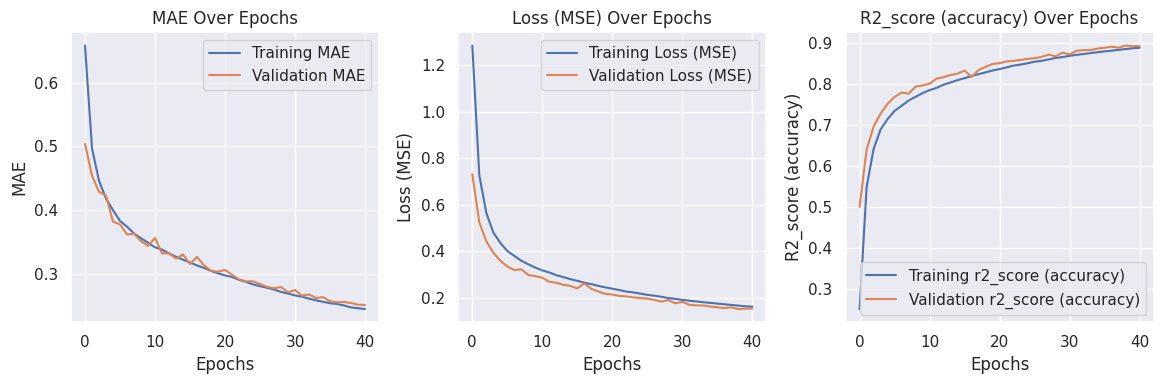

In [8]:
sns.set()
plt.figure(figsize=(12, 4))

# Plotting MAE ( correlated with loss )
plt.subplot(1, 3, 1)
plt.plot(history_1.history['mae'], label='Training MAE')
plt.plot(history_1.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plotting loss or MSE
plt.subplot(1, 3, 2)
plt.plot(history_1.history['loss'], label='Training Loss (MSE)')
plt.plot(history_1.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Loss (MSE) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plotting r2 or accuracy
plt.subplot(1, 3, 3)
plt.plot(history_1.history['r2_score'], label='Training r2_score (accuracy)')
plt.plot(history_1.history['val_r2_score'], label='Validation r2_score (accuracy)')
plt.title('R2_score (accuracy) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('R2_score (accuracy)')
plt.legend()

plt.tight_layout()
plt.show()

**Observation:** overall, the training and validation loss decreased per epochs in training process. It means that our model is learning per epcohs. We tolerated 2 times that validation loss started to increase as it is too strict to stop as soon as overfitting signs occur. We are working in shuffled dataset, therefore, random increasement in validation loss may occur and does not represent as overfitting signs. We may overfitted the model a bit but it was worth the tradeoff. In loss graphs, we can see that loss decreased less overtime, It seem 0.001 is a small learning rate for this problem as the curve is pretty smooth. 
- With 0.89 r2_score testing in validation set in the last epoch, this model is quite good. However, there are plenty rooms for improvement with adjusting hyperparameters.

### Plotting validation residuals

11/11 [==============================] - 0s 2ms/step


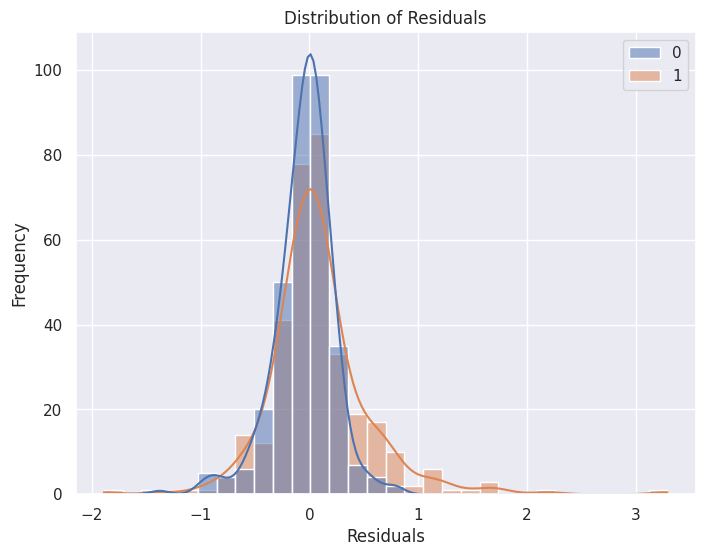

In [9]:
predictions_1 = model_1.predict(validation_inputs)
residuals_1 = validation_targets - predictions_1

sns.set()
plt.figure(figsize=(8, 6))
sns.histplot(residuals_1, kde=True, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

**Observation:** the residuals normally distributed. However, it is postive skewed with a long tail. It seems that this model overestimated some players, maybe the dataset needs more columns to explain this. 

## Model 2 (improving from model 1)

- Learning rate is a factor should be considered as it helps machine to decide whether to learn fast or slow to reach loss function minimum effectively
- Therefore, a constant learning rate is not good as every epochs the machines just learn a same amount.
- As for first few epochs, we want the computer to move fast towards minimum. Later on, we want our learning rate to decrease to make sure that we can reach minimum at some point.
- There are many types of learning rate schedulers, the most naive is that we choose a high specific learning rate to begin with first few epochs then if we past those epochs we choose another lower specific number. However, we can not apply this as early stopping occur to prevent overffitting hence some learning rates will not even participate.
- Another smart stategy is to use exponential schedule, which decreasses learning rate gradually per every epcohs. 

***Second model will use exponential learning rate schedule stategy and mae as loss function  with stochastic gradient descent optimizer with depth = 3 (stacking 1 more layer) and width = 100.  Also so we will tolerate 2 time when validation loss start to increase, if another occur, the train process stop immediately***

### Design and train

In [10]:
initial_learning_rate = 1e-3
import math
decay_steps = 200
decay_rate = 0.9

# Create an exponential decay learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate)

output_size = 2
hidden_layer_size = 100

model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),  # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),  # 2nd hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),  # 3rd hidden layer
    tf.keras.layers.Dense(output_size, activation='linear')       # output layer
])

# Choose an optimizer with the exponential learning rate schedule
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

# Compile the model with the chosen optimizer and loss function
model_2.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae', 'R2Score'])


# set the batch size
batch_size = 100

# set a maximum number of training epochs
max_epochs = 100

# set an early stopping mechanism
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 2)

# fit the model
history_2 = model_2.fit(train_inputs, 
                    train_targets,
                    batch_size=batch_size, 
                    epochs=max_epochs,
                    callbacks=[early_stopping], 
                    validation_data=(validation_inputs, validation_targets),
                    verbose = 2,
                    )  

Epoch 1/100
27/27 - 1s - loss: 1.5271 - mse: 1.5271 - mae: 0.7017 - r2_score: 0.1817 - val_loss: 0.8981 - val_mse: 0.8981 - val_mae: 0.6028 - val_r2_score: 0.4155 - 936ms/epoch - 35ms/step
Epoch 2/100
27/27 - 0s - loss: 0.9773 - mse: 0.9773 - mae: 0.5732 - r2_score: 0.4510 - val_loss: 0.5662 - val_mse: 0.5662 - val_mae: 0.4837 - val_r2_score: 0.6207 - 109ms/epoch - 4ms/step
Epoch 3/100
27/27 - 0s - loss: 0.7074 - mse: 0.7074 - mae: 0.4874 - r2_score: 0.5839 - val_loss: 0.4256 - val_mse: 0.4256 - val_mae: 0.4244 - val_r2_score: 0.7085 - 138ms/epoch - 5ms/step
Epoch 4/100
27/27 - 0s - loss: 0.5756 - mse: 0.5756 - mae: 0.4397 - r2_score: 0.6504 - val_loss: 0.3607 - val_mse: 0.3607 - val_mae: 0.3861 - val_r2_score: 0.7506 - 117ms/epoch - 4ms/step
Epoch 5/100
27/27 - 0s - loss: 0.5099 - mse: 0.5099 - mae: 0.4128 - r2_score: 0.6845 - val_loss: 0.3317 - val_mse: 0.3317 - val_mae: 0.3731 - val_r2_score: 0.7694 - 101ms/epoch - 4ms/step
Epoch 6/100
27/27 - 0s - loss: 0.4679 - mse: 0.4679 - mae: 

## Evaluate

#### Plotting loss, accuracy and metrics score per epochs

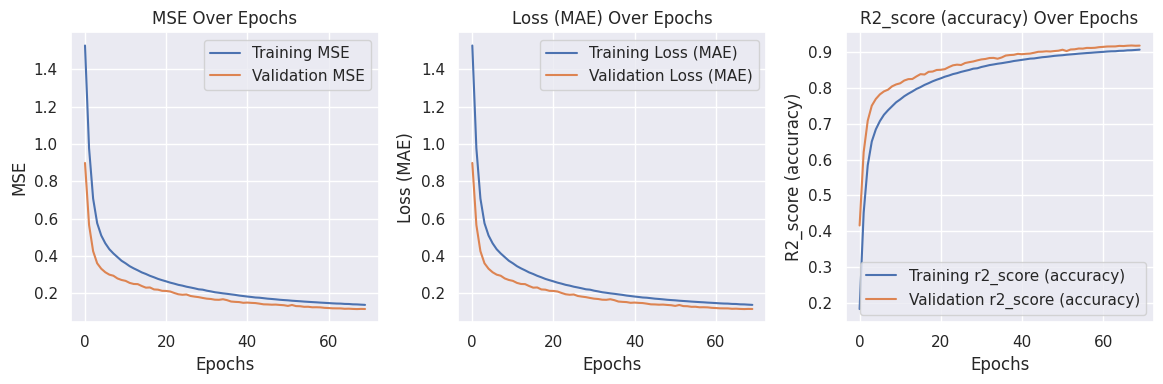

In [11]:
sns.set()
plt.figure(figsize=(12, 4))

# Plotting MSE ( also loss )
plt.subplot(1, 3, 1)
plt.plot(history_2.history['mse'], label='Training MSE')
plt.plot(history_2.history['val_mse'], label='Validation MSE')
plt.title('MSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Plotting loss or MAE
plt.subplot(1, 3, 2)
plt.plot(history_2.history['loss'], label='Training Loss (MAE)')
plt.plot(history_2.history['val_loss'], label='Validation Loss (MAE)')
plt.title('Loss (MAE) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()

# Plotting r2 or accuracy
plt.subplot(1, 3, 3)
plt.plot(history_2.history['r2_score'], label='Training r2_score (accuracy)')
plt.plot(history_2.history['val_r2_score'], label='Validation r2_score (accuracy)')
plt.title('R2_score (accuracy) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('R2_score (accuracy)')
plt.legend()

plt.tight_layout()
plt.show()

**Observation:** overall, the training and validation loss decreased per epochs in training process. It means that our model is learning per epcohs. 
This time, the loss curve is even smoother at those last epcohs as learning rate decreased over time. Loss value reached 0.2 at 40th epoch while the first one reached after only 30 epochs. 
- The r2_score for validation set at last epoch is 0.92 which showed improvements. It seemed stacking one more layers and use a better learning rate stategy helped to get better results.
- However, this stategy was time-consuming (we set initial rate 0.001 which was quite small as shown in first model, therefore the process is slower ) as learning rate kept decreasing, meaning we need another strategy which knows how to adjust learning rate.

### Plotting validatation dataset residuals

11/11 [==============================] - 0s 2ms/step


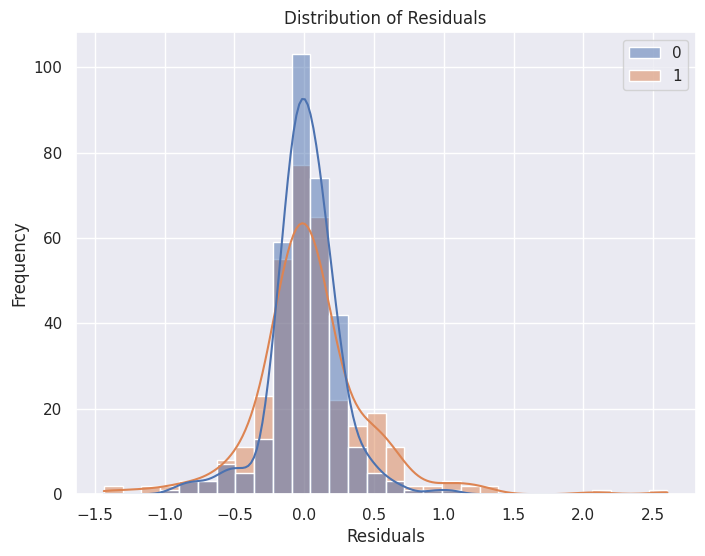

In [12]:
predictions_2 = model_2.predict(validation_inputs)
residuals_2 = validation_targets - predictions_2

sns.set()
plt.figure(figsize=(8, 6))
sns.histplot(residuals_2, kde=True, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

**Observation:** the residuals normally distributed. However, it is postive skewed with a long tail. It seems that this model overestimated some players, maybe the dataset needs more columns to explain this. However, compared to model 1, the model improved by overestimating a bit lower.

## Model 3 (improving from model 2)

***Third model will use RMProp learning rate schedule combine with momentum stategy and mae as loss function with adam optimizer with depth = 3 and width = 200 ( adding 100 more neurons to each hidden layers).  Also so we will tolerate 2 time when validation loss start to increase, if another occur, the train process stop immediately***

- AdaGrad a is like exponential schedule stategy, decreasing learning rate as time went by. However, AdaGrad introduced its own recursive function which allow previous epoch gradient values to participate.
- It is smarter as this value provides information on how fast the previous epcohs was. If it was fast then learning rate will decrease even more.
- RMSprop is basically AdaGrad, however, the function RMSprop introduced is not monotonously increasing as AdaGrad's ones.
- Adam is RMSprop combined with momentum which help to get out of loss function local minima

### Design and train

In [13]:
output_size = 2
hidden_layer_size = 200
lr = 1e-3
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), #3rd hidden layer
    tf.keras.layers.Dense(output_size, activation='linear') # output layer
])
opt = tf.keras.optimizers.Adam(learning_rate=lr)
# choosing optimizer and loss function
model_3.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mse','mae', 'R2Score'])

# set the batch size
batch_size = 100

# set a maximum number of training epochs
max_epochs = 100

# set an early stopping mechanism
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 2)

# fit the model
history_3 = model_3.fit(train_inputs, 
                    train_targets,
                    batch_size=batch_size, 
                    epochs=max_epochs,
                    callbacks=[early_stopping], 
                    validation_data=(validation_inputs, validation_targets),
                    verbose = 2 
                    )  

Epoch 1/100
27/27 - 1s - loss: 0.4951 - mse: 0.8232 - mae: 0.4951 - r2_score: 0.5429 - val_loss: 0.2895 - val_mse: 0.2572 - val_mae: 0.2895 - val_r2_score: 0.8201 - 1s/epoch - 45ms/step
Epoch 2/100
27/27 - 0s - loss: 0.2462 - mse: 0.2246 - mae: 0.2462 - r2_score: 0.8510 - val_loss: 0.1844 - val_mse: 0.0973 - val_mae: 0.1844 - val_r2_score: 0.9306 - 173ms/epoch - 6ms/step
Epoch 3/100
27/27 - 0s - loss: 0.1996 - mse: 0.1230 - mae: 0.1996 - r2_score: 0.9150 - val_loss: 0.2037 - val_mse: 0.0950 - val_mae: 0.2037 - val_r2_score: 0.9330 - 146ms/epoch - 5ms/step
Epoch 4/100
27/27 - 0s - loss: 0.1708 - mse: 0.0889 - mae: 0.1708 - r2_score: 0.9374 - val_loss: 0.1558 - val_mse: 0.0756 - val_mae: 0.1558 - val_r2_score: 0.9456 - 150ms/epoch - 6ms/step
Epoch 5/100
27/27 - 0s - loss: 0.1356 - mse: 0.0629 - mae: 0.1356 - r2_score: 0.9547 - val_loss: 0.1466 - val_mse: 0.0510 - val_mae: 0.1466 - val_r2_score: 0.9648 - 136ms/epoch - 5ms/step
Epoch 6/100
27/27 - 0s - loss: 0.1313 - mse: 0.0567 - mae: 0.1

## Evaluate

### Plotting loss, accuracy and metrics score per epochs

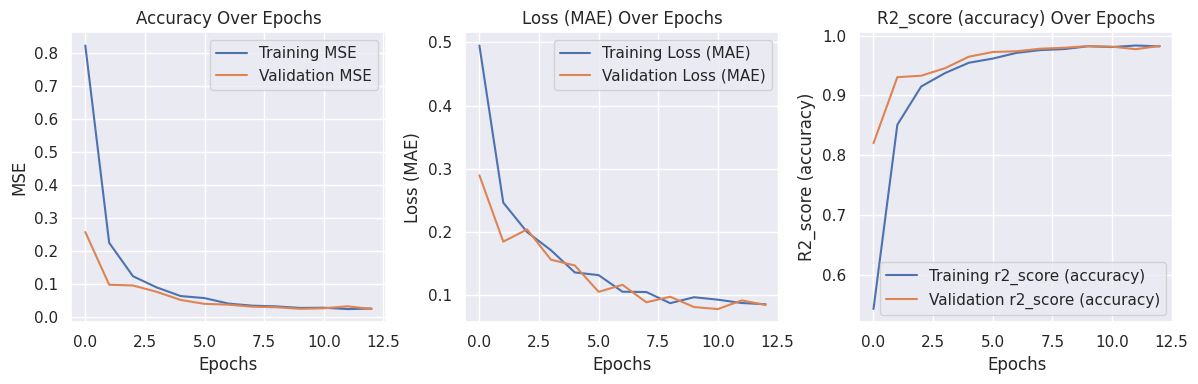

In [14]:
sns.set()
plt.figure(figsize=(12, 4))

# Plotting MSE (correlated with loss) 
plt.subplot(1, 3, 1)
plt.plot(history_3.history['mse'], label='Training MSE')
plt.plot(history_3.history['val_mse'], label='Validation MSE')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Plotting loss or MAE
plt.subplot(1, 3, 2)
plt.plot(history_3.history['loss'], label='Training Loss (MAE)')
plt.plot(history_3.history['val_loss'], label='Validation Loss (MAE)')
plt.title('Loss (MAE) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()

# Plotting r2 or accuracy
plt.subplot(1, 3, 3)
plt.plot(history_3.history['r2_score'], label='Training r2_score (accuracy)')
plt.plot(history_3.history['val_r2_score'], label='Validation r2_score (accuracy)')
plt.title('R2_score (accuracy) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('R2_score (accuracy)')
plt.legend()
plt.tight_layout()
plt.show()

**Observation:** overall, the training and validation loss decreased per epochs in training process. It means that our model is learning per epcohs. However, it was clear this learning rate stategy helped the model learn faster as the loss was lower than 0.1 after only 13 epochs. We can see that the loss line was no longer smooth as learning rate was adjusted to increase or decrease depending on previous epoch.

### Plotting validation dataset residuals

11/11 [==============================] - 0s 2ms/step


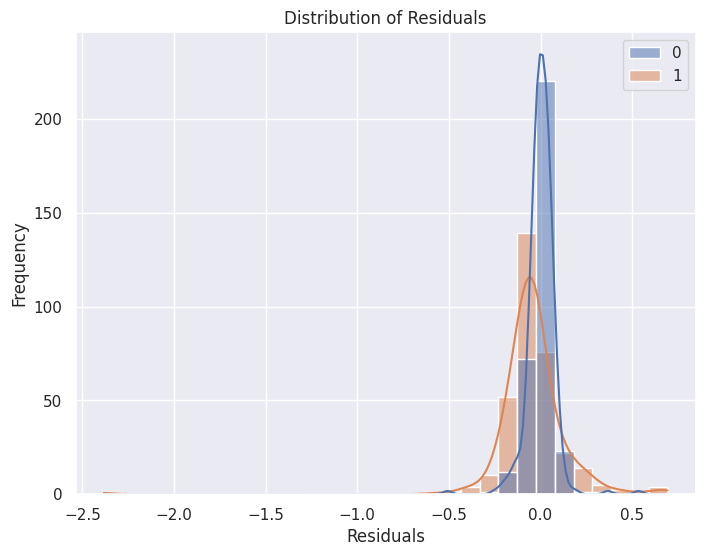

In [15]:
predictions_3 = model_3.predict(validation_inputs)
residuals_3 = validation_targets - predictions_3

sns.set()
plt.figure(figsize=(8, 6))
sns.histplot(residuals_3, kde=True, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

**Observation:** the residuals normally distributed. However, it is negative skewed with a long tail. It seems that this model underestimated some players, maybe the dataset needs more columns to explain this. However, compared to model 2 and 1, the model only uderestimated some really small amount of samples (mabe true errors) in validation dataset. Overall, if not considering that specific outliers, most of the data is predicted with a much lower variance compared to other models. It seemed that adding more neurons and changing learning rate stategy help us to achieve a much better model.

### Metrics score

To make sure all the changes above are not for overfitting validation dataset, we need to see if the model predicts well on an unseen dataset which is test dataset

In [16]:
test_loss, mse, mae, r_squared = model_3.evaluate(test_inputs, test_targets)

print(f'Test Loss: {round(test_loss,3)}')
print(f'Test MSE: {round(mse,3)}')
print(f'Test MAE: {round(mae,3)}')

n = test_samples_count  # number of samples
p = test_inputs.shape[1]  # number of predictors (features)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print(f'Test R-squared: {round(r_squared,3)}')
print(f'Test Adjusted R-squared: {round(adjusted_r_squared,3)}')

11/11 [==============================] - 0s 3ms/step - loss: 0.0881 - mse: 0.0284 - mae: 0.0881 - r2_score: 0.9804
Test Loss: 0.088
Test MSE: 0.028
Test MAE: 0.088
Test R-squared: 0.98
Test Adjusted R-squared: 0.978


In [17]:
print('\nTest loss: {0:.2f}. Test adjusted R2-score: {1:.2f}'.format(test_loss, adjusted_r_squared))


Test loss: 0.09. Test adjusted R2-score: 0.98


**Obsservation:** 0.98 score is a superb result, a lot of improvements were shown here. Some changes in hyperparameters really help to improve the model giving a much better result.